In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from numpy.random import seed
from scipy import stats
from sklearn import preprocessing
import re

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Crea los lags de un df
def lags(dfOriginal, nLag):
    df = dfOriginal.copy()
    for i in df.columns:
        for j in range(1, (nLag+1)):
            palabra = i.split(' ', 1)[0]
            atributo = 'Lag_'+palabra+"_"+str(j)
            df[atributo] = df[i].shift(j)
    
    # Contador para ver cuantos lags hay y así poder eliminar automáticamente los atributos originales
    cont = 0
    for i in df.columns:
        cont = cont + len(re.findall("Lag*", i))
            
    df = df.drop(df.iloc[:, range((len(df.columns)-cont-1))], axis=1) # delete original attributes
    cols = list(df.columns)
    cols = cols[1:] + [cols[0]] 
    df = df[cols]
    
    return df

In [4]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE = [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagsco2 = np.sum([len(re.findall("Lag_co2*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagsco2], prueba_X_test.iloc[:,-lagsco2:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_co2_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        
    return testPredRMSE, testPredMAE, preds

In [5]:
def testCO2Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.3, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['co2'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)

    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel CO2 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de CO2')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [6]:
df = pd.read_csv("21-12-21-datos.csv",
                 sep=";",
                 decimal=",",
                 parse_dates=['time_index'],
                 dayfirst=True,
                 index_col="time_index")

In [7]:
df

,temperature,relativehumidity,pm25,pm10,numberofincoming,numberofoutgoing,co2,ocupacion
time_index,,,,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,68.0,88.0,594.85,0.0
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,186.0,265.0,590.77,0.0
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,354.0,492.0,578.66,0.0
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,80.0,114.0,581.25,0.0
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,467.0,642.0,586.75,0.0
...,...,...,...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,0.0,0.0,409.35,0.0
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,0.0,0.0,408.84,0.0
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,0.0,0.0,408.72,0.0


In [8]:
df_final = df[['temperature', 'relativehumidity', 'pm25', 'pm10', 'co2']]
# df_final.reset_index(inplace=True, drop=True)
df_final

,temperature,relativehumidity,pm25,pm10,co2
time_index,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,594.85
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,590.77
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,578.66
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,581.25
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,586.75
...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,409.35
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,408.84
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,408.72


In [9]:
df_lags_5 = lags(df_final, 5) #predecir a 5 minutos
df_lags_5 = df_lags_5.iloc[5:,:].reset_index(drop=True)
df_lags_5

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,co2
0,28.09,28.03,27.94,27.66,27.34,48.43,48.59,49.70,49.45,49.74,...,5.71,6.38,7.75,13.00,586.75,581.25,578.66,590.77,594.85,579.95
1,28.06,28.09,28.03,27.94,27.66,48.02,48.43,48.59,49.70,49.45,...,4.62,5.71,6.38,7.75,579.95,586.75,581.25,578.66,590.77,609.86
2,25.93,28.06,28.09,28.03,27.94,51.06,48.02,48.43,48.59,49.70,...,4.62,4.62,5.71,6.38,609.86,579.95,586.75,581.25,578.66,616.17
3,25.96,25.93,28.06,28.09,28.03,50.89,51.06,48.02,48.43,48.59,...,31.75,4.62,4.62,5.71,616.17,609.86,579.95,586.75,581.25,617.56
4,25.99,25.96,25.93,28.06,28.09,50.76,50.89,51.06,48.02,48.43,...,36.88,31.75,4.62,4.62,617.56,616.17,609.86,579.95,586.75,620.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16845,18.82,18.82,18.83,18.86,18.87,50.07,50.06,50.07,50.08,50.06,...,19.70,19.10,18.50,18.50,409.86,409.15,408.77,408.92,409.00,409.35
16846,18.81,18.82,18.82,18.83,18.86,50.12,50.07,50.06,50.07,50.08,...,20.10,19.70,19.10,18.50,409.35,409.86,409.15,408.77,408.92,408.84
16847,18.82,18.81,18.82,18.82,18.83,50.13,50.12,50.07,50.06,50.07,...,20.40,20.10,19.70,19.10,408.84,409.35,409.86,409.15,408.77,408.72
16848,18.78,18.82,18.81,18.82,18.82,50.07,50.13,50.12,50.07,50.06,...,20.80,20.40,20.10,19.70,408.72,408.84,409.35,409.86,409.15,408.75


In [10]:
df_lags_10 = lags(df_final, 10) #predecir a 10 minutos
df_lags_10 = df_lags_10.iloc[10:,:].reset_index(drop=True)
df_lags_10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_co2_6,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,co2
0,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,27.66,27.34,...,617.56,616.17,609.86,579.95,586.75,581.25,578.66,590.77,594.85,623.75
1,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,27.66,...,620.53,617.56,616.17,609.86,579.95,586.75,581.25,578.66,590.77,617.60
2,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,...,623.75,620.53,617.56,616.17,609.86,579.95,586.75,581.25,578.66,610.68
3,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,...,617.60,623.75,620.53,617.56,616.17,609.86,579.95,586.75,581.25,614.24
4,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,...,610.68,617.60,623.75,620.53,617.56,616.17,609.86,579.95,586.75,614.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16840,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,409.15,408.77,408.92,409.00,408.89,408.49,409.79,409.20,408.69,409.35
16841,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,409.86,409.15,408.77,408.92,409.00,408.89,408.49,409.79,409.20,408.84
16842,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,409.35,409.86,409.15,408.77,408.92,409.00,408.89,408.49,409.79,408.72
16843,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,408.84,409.35,409.86,409.15,408.77,408.92,409.00,408.89,408.49,408.75


In [11]:
df_lags_15 = lags(df_final, 15) #predecir a 15 minutos
df_lags_15 = df_lags_15.iloc[15:,:].reset_index(drop=True)
df_lags_15

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,Lag_co2_11,Lag_co2_12,Lag_co2_13,Lag_co2_14,Lag_co2_15,co2
0,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,...,617.56,616.17,609.86,579.95,586.75,581.25,578.66,590.77,594.85,606.56
1,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,...,620.53,617.56,616.17,609.86,579.95,586.75,581.25,578.66,590.77,602.53
2,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,...,623.75,620.53,617.56,616.17,609.86,579.95,586.75,581.25,578.66,601.45
3,26.17,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,...,617.60,623.75,620.53,617.56,616.17,609.86,579.95,586.75,581.25,596.29
4,26.18,26.17,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,...,610.68,617.60,623.75,620.53,617.56,616.17,609.86,579.95,586.75,592.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16835,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,408.49,409.79,409.20,408.69,408.38,408.45,408.87,409.12,409.72,409.35
16836,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,408.89,408.49,409.79,409.20,408.69,408.38,408.45,408.87,409.12,408.84
16837,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,409.00,408.89,408.49,409.79,409.20,408.69,408.38,408.45,408.87,408.72
16838,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,408.92,409.00,408.89,408.49,409.79,409.20,408.69,408.38,408.45,408.75


# Linear Regression

## 5 minutos

In [12]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_5 = pd.DataFrame(scaler.fit_transform(df_lags_5), columns=df_lags_5.columns)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_5.iloc[:,:-1], df_lags_norm_5.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [14]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [15]:
modelLR.coef_

array([[ 1.31547510e-01, -6.27869645e-03, -8.17456616e-02,
        -9.42365799e-03, -3.52914845e-02,  8.30461534e-02,
        -9.97289043e-02, -1.69941667e-02,  3.31617808e-02,
        -1.33500228e-04,  3.10439039e-01, -5.99620658e-01,
        -7.95174378e-01,  9.26461644e-01, -1.20750334e-01,
        -2.80531187e-01,  5.89061769e-01,  7.52343081e-01,
        -9.00753944e-01,  1.16354595e-01,  1.13280894e+00,
        -2.93495645e-02, -8.81931448e-03,  4.17943974e-03,
        -1.03604964e-01]])

In [16]:
modelLR.intercept_

array([0.0016442])

In [17]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_5['co2'].to_numpy().reshape(-1, 1))

array([[0.11537059],
       [0.13520809],
       [0.13939314],
       ...,
       [0.00180401],
       [0.00182391],
       [0.00236777]])

In [18]:
# make predictions
trainPredict = modelLR.predict(X_train)
testPredict = modelLR.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
y_train_transformed = scaler.inverse_transform(y_train.to_numpy())
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
y_test_transformed = scaler.inverse_transform(y_test.to_numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_transformed, trainPredict.ravel()))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_transformed, testPredict.ravel()))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.62 RMSE
Test Score: 10.03 RMSE


In [20]:
# Recursive predictions
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_5['co2'].to_numpy().reshape(-1, 1))

rmse_5, mae_5, preds_5 = recursiveStepsAhead(X_test, y_test, 5, scaler, modelLR)

Test Score Step 1
RMSE 10.85
MAE 4.63
Test Score Step 2
RMSE 13.66
MAE 7.12
Test Score Step 3
RMSE 17.35
MAE 9.86
Test Score Step 4
RMSE 21.22
MAE 12.66
Test Score Step 5
RMSE 25.23
MAE 15.47


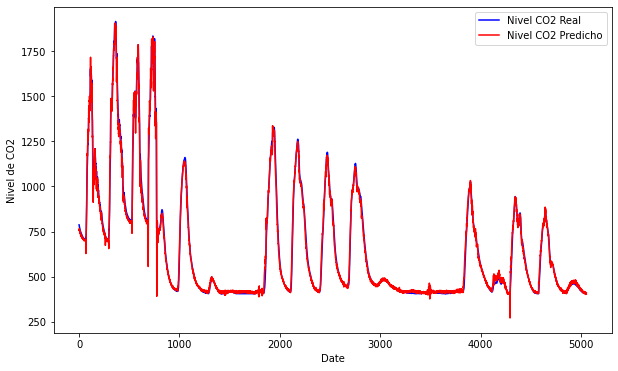

In [21]:
plt.figure(figsize=(10,6))
plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
plt.plot(preds_5[4] , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

## 10 minutos

In [22]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_10 = pd.DataFrame(scaler.fit_transform(df_lags_10), columns=df_lags_10.columns)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_10.iloc[:,:-1], df_lags_norm_10.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [24]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [25]:
modelLR.coef_

array([[ 0.12582064, -0.00158447, -0.09490568, -0.0147944 ,  0.02346009,
        -0.00570566, -0.05653884,  0.02484114,  0.01046011, -0.0127993 ,
         0.09043518, -0.09854649, -0.01832968,  0.03549905,  0.00210183,
        -0.05968819,  0.03385105,  0.0203004 , -0.04604631,  0.03969555,
         0.40539311, -0.91024234, -0.85830576,  1.03122449, -0.25942131,
        -0.11511318,  0.61815303,  0.17080475, -0.09627733, -0.38810285,
        -0.38255486,  0.89986824,  0.82293127, -1.00396336,  0.24701705,
         0.13433581, -0.66814808, -0.14535522,  0.12719773,  0.37186513,
         1.12751929, -0.03145474, -0.01026204,  0.00530765, -0.08612519,
         0.02310915, -0.01940202, -0.02781952,  0.01813754, -0.00448614]])

In [26]:
modelLR.intercept_

array([0.00170168])

In [27]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_10['co2'].to_numpy().reshape(-1, 1))

rmse_10, mae_10, preds_10 = recursiveStepsAhead(X_test, y_test, 10, scaler, modelLR)

Test Score Step 1
RMSE 11.15
MAE 5.09
Test Score Step 2
RMSE 14.45
MAE 7.95
Test Score Step 3
RMSE 18.72
MAE 11.08
Test Score Step 4
RMSE 23.22
MAE 14.31
Test Score Step 5
RMSE 27.88
MAE 17.56
Test Score Step 6
RMSE 32.58
MAE 20.82
Test Score Step 7
RMSE 37.28
MAE 24.09
Test Score Step 8
RMSE 42.01
MAE 27.36
Test Score Step 9
RMSE 46.73
MAE 30.62
Test Score Step 10
RMSE 51.44
MAE 33.88


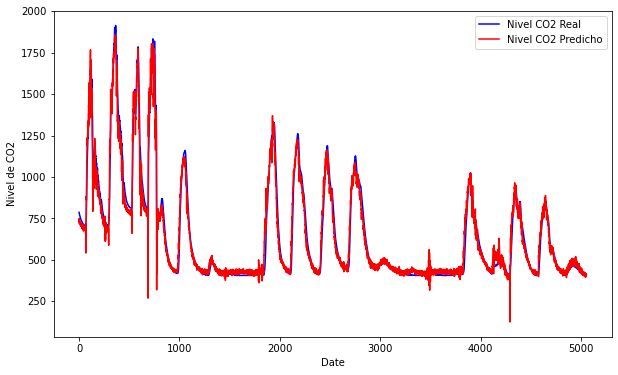

In [28]:
plt.figure(figsize=(10,6))
plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
plt.plot(preds_10[9] , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

## 15 minutos

In [29]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_15 = pd.DataFrame(scaler.fit_transform(df_lags_15), columns=df_lags_15.columns)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_15.iloc[:,:-1], df_lags_norm_15.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [31]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [32]:
modelLR.coef_

array([[ 1.22868053e-01, -2.00016025e-03, -9.08278057e-02,
        -1.81193715e-02,  1.65194050e-02, -9.71209662e-03,
        -2.73165884e-02,  1.78867303e-02, -4.24662034e-03,
         2.57869761e-03, -2.09053572e-02,  4.95900530e-02,
        -5.15729204e-02, -2.40061696e-02,  3.80024704e-02,
         8.85989003e-02, -9.87514371e-02, -1.50854263e-02,
         3.66001419e-02,  1.10443394e-03, -5.73322496e-02,
         3.65847412e-02,  1.72945548e-02, -4.30600726e-02,
         4.75316874e-02, -4.21537264e-02,  5.63935397e-03,
         1.40153228e-02,  2.10306951e-02, -1.29245416e-02,
         4.48571962e-01, -7.13365311e-01, -8.52297621e-01,
         8.59857712e-01, -1.43297441e-02, -2.88266854e-02,
         1.03435510e+00, -4.07904863e-02, -4.30199991e-01,
         2.68337788e-01, -9.26586512e-01, -9.20279241e-01,
         6.28592390e-01,  8.12124276e-01, -1.03343387e-01,
        -4.26610171e-01,  7.01975305e-01,  8.18740299e-01,
        -8.30857866e-01,  5.61159137e-04,  5.49504873e-0

In [33]:
modelLR.intercept_

array([0.00168078])

In [34]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_15['co2'].to_numpy().reshape(-1, 1))

rmse_15, mae_15, preds_15 = recursiveStepsAhead(X_test, y_test, 15, scaler, modelLR)

Test Score Step 1
RMSE 11.31
MAE 5.40
Test Score Step 2
RMSE 14.84
MAE 8.48
Test Score Step 3
RMSE 19.36
MAE 11.85
Test Score Step 4
RMSE 24.12
MAE 15.34
Test Score Step 5
RMSE 29.04
MAE 18.86
Test Score Step 6
RMSE 34.03
MAE 22.40
Test Score Step 7
RMSE 39.04
MAE 25.95
Test Score Step 8
RMSE 44.13
MAE 29.53
Test Score Step 9
RMSE 49.25
MAE 33.12
Test Score Step 10
RMSE 54.39
MAE 36.71
Test Score Step 11
RMSE 59.53
MAE 40.29
Test Score Step 12
RMSE 64.64
MAE 43.86
Test Score Step 13
RMSE 69.74
MAE 47.43
Test Score Step 14
RMSE 74.80
MAE 50.98
Test Score Step 15
RMSE 79.84
MAE 54.52


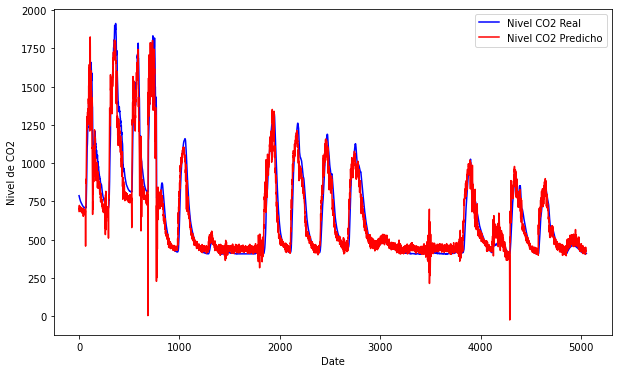

In [35]:
plt.figure(figsize=(10,6))
plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
plt.plot(preds_15[14] , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

# Random Forest

Test Score Step 1
RMSE 30.81
MAE 14.81
Test Score Step 2
RMSE 35.60
MAE 20.52
Test Score Step 3
RMSE 42.72
MAE 27.28
Test Score Step 4
RMSE 52.18
MAE 35.23
Test Score Step 5
RMSE 64.61
MAE 44.64


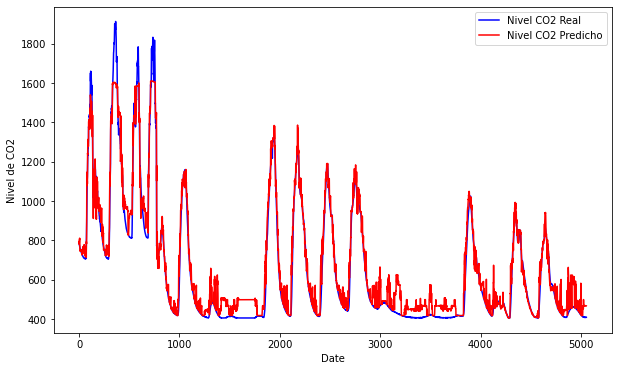

In [36]:
rmse_rf_5, mae_rf_5, preds_rf_5 = testCO2Quality(df_lags_5, 5, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 33.19
MAE 15.59
Test Score Step 2
RMSE 38.22
MAE 21.55
Test Score Step 3
RMSE 45.32
MAE 28.40
Test Score Step 4
RMSE 54.61
MAE 36.42
Test Score Step 5
RMSE 67.79
MAE 46.61
Test Score Step 6
RMSE 83.22
MAE 57.73
Test Score Step 7
RMSE 102.51
MAE 70.75
Test Score Step 8
RMSE 122.58
MAE 84.06
Test Score Step 9
RMSE 140.13
MAE 95.81
Test Score Step 10
RMSE 154.69
MAE 105.75


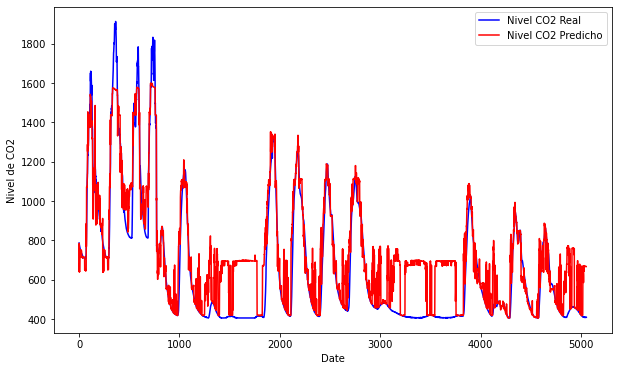

In [37]:
rmse_rf_10, mae_rf_10, preds_rf_10 = testCO2Quality(df_lags_10, 10, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 34.69
MAE 16.13
Test Score Step 2
RMSE 39.24
MAE 21.93
Test Score Step 3
RMSE 45.92
MAE 28.83
Test Score Step 4
RMSE 54.31
MAE 36.38
Test Score Step 5
RMSE 66.47
MAE 46.23
Test Score Step 6
RMSE 81.00
MAE 57.23
Test Score Step 7
RMSE 101.26
MAE 71.33
Test Score Step 8
RMSE 120.78
MAE 84.66
Test Score Step 9
RMSE 138.62
MAE 96.99
Test Score Step 10
RMSE 153.12
MAE 107.32
Test Score Step 11
RMSE 170.66
MAE 118.95
Test Score Step 12
RMSE 186.55
MAE 129.48
Test Score Step 13
RMSE 198.39
MAE 137.67
Test Score Step 14
RMSE 211.96
MAE 146.59
Test Score Step 15
RMSE 224.22
MAE 154.65


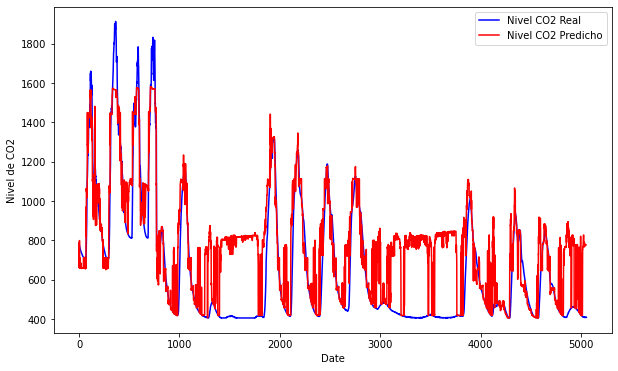

In [38]:
rmse_rf_15, mae_rf_15, preds_rf_15 = testCO2Quality(df_lags_15, 15, RandomForestRegressor(random_state=seed_value))